In [19]:
%load_ext autoreload
%autoreload 2
from configs import project_config
import pickle
import numpy as np
import torch
import os
from src.generative_modelling.models.ClassVPSDEDiffusion import VPSDEDiffusion
import matplotlib.pyplot as plt
from configs.RecursiveVPSDE.Markovian_fQuadSinHF.recursive_Markovian_PostMeanScore_fQuadSinHF2_LowFTh_T1024_H05_tl_110data_StbleTgt_FULLDATA import get_config

from configs.RecursiveVPSDE.Markovian_fQuadSinHF.recursive_Markovian_PostMeanScore_fQuadSinHF2_LowFTh_T64_H05_tl_110data_StbleTgt_FULLDATA import get_config

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
import shutil
source_dir = "/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/ExperimentResults/TSPM_Markovian/8DDims/"
sink_dir = "/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/ExperimentResults/TSPM_Markovian/8DDimsHighNoise/"
for f in os.listdir(source_dir):
    if "Diff100" in f:
        print(source_dir+f)
        shutil.move(src=source_dir+f, dst=sink_dir+f)

In [21]:
config = get_config()
assert config.feat_thresh != 1.

#data = np.load(config.data_path, allow_pickle=True).flatten()

#n = (plt.hist(data, bins=200, density=True))
#100*(n[0][(np.abs(n[1])>1.5)[:-1]].sum()/n[0].sum())

In [22]:
from IPython.core.magic import register_cell_magic

@register_cell_magic
def skip(line, cell):
    return

In [23]:
def rmse_ignore_nans(y_true, y_pred):
    return np.nanmean((y_true-y_pred)**2)

def plot_drift_estimator(mean, mean_min, mean_max, numpy_Xs, true_drift, Nepoch, dirname, label, toSave: bool = True):
    if "BiPot" in config.data_path:
        ts_type_str = "fBiPot"
    elif "SinLog" in config.data_path:
        ts_type_str = "fSinLog"
    elif "QuadSinHF" in config.data_path:
        ts_type_str = "fQuadSinHF2"
    fig, ax = plt.subplots(figsize=(14, 9))
    ax.scatter(numpy_Xs, true_drift, color="red", label="True Drift")
    ymin = mean - mean_min
    ymax = mean_max - mean
    ymin[ymin < 0.] = 0.
    ymax[ymax < 0.] = 0.
    plt.errorbar(numpy_Xs, mean, yerr=[ymin, ymax], xerr=None, fmt='o', color="blue", alpha=0.4)
    plt.scatter(numpy_Xs, mean, label="Estimated Drift", color="blue")
    ax.set_title(rf"Score Estimator for {label}", fontsize=40)
    ax.tick_params(labelsize=38)
    ax.set_xlabel("State $Y$", fontsize=38)
    ax.set_ylabel("Drift Value", fontsize=38)
    ax.legend(fontsize=24)
    plt.grid(True)
    plt.tight_layout()
    if toSave:
        plt.savefig((root_dir +f"DiffusionModelPresentationImages/TSPM_Markovian/{dirname}/TSPM_MLP_PM_ST_{ts_type_str}_DriftEvalExp_{Nepoch}Nep_{config.loss_factor}LFac").replace(
                ".", "") + ".png", bbox_inches='tight')
    plt.show()
    plt.close()
def plot_ewma_losses(epochs, losses):
    start_idx = 0
    def compute_ema(loss_tensor, beta):
        ema_values = np.zeros_like(loss_tensor)  # Initialize EMA tensor
        ema_values[0] = loss_tensor[0]  # First value stays the same

        for i in range(1, len(loss_tensor)):
            ema_values[i] = beta * ema_values[i - 1] + (1 - beta) * loss_tensor[i]

        return ema_values
    # Define EMA decay rates
    beta_short = 0.9   # Short-term trend (reacts quickly)
    beta_long = 0.92   # Long-term trend (smoother)

    # Compute EMAs
    short_term_ema = compute_ema(losses, beta_short)
    long_term_ema = compute_ema(losses, beta_long)
    plt.scatter(epochs[start_idx:], (short_term_ema[start_idx:]),s=2, label="Short Term Loss")
    print(np.min(short_term_ema[start_idx:]), np.min(long_term_ema[start_idx:]))
    print(long_term_ema[-1])
    plt.yscale("log")
    plt.legend()
    plt.show()
    plt.scatter(epochs[start_idx:], (long_term_ema[start_idx:]),s=2, label="Long Term Loss")
    plt.yscale("log")
    plt.legend()
    plt.show()
    return long_term_ema

In [24]:
config = get_config()
#assert config.enforce_fourier_mean_reg
root_dir ="/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/"

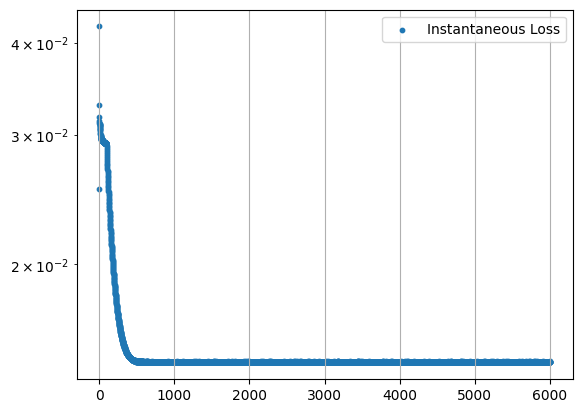

5999

In [25]:
with open((config.scoreNet_trained_path.replace("/trained_models/", "/training_losses/")+ "_loss"), 'rb') as f:
        losses = (np.array(pickle.load(f)).astype(float))
Nepochs_losses = np.arange(losses.shape[0])
plt.scatter(Nepochs_losses,  losses, s=10, label="Instantaneous Loss")
plt.yscale("log")
plt.legend()
plt.grid(True)
plt.show()
plt.close()
Nepochs_losses[-1]

0.014736184912578217 0.014736872975008777
0.014742428462678439


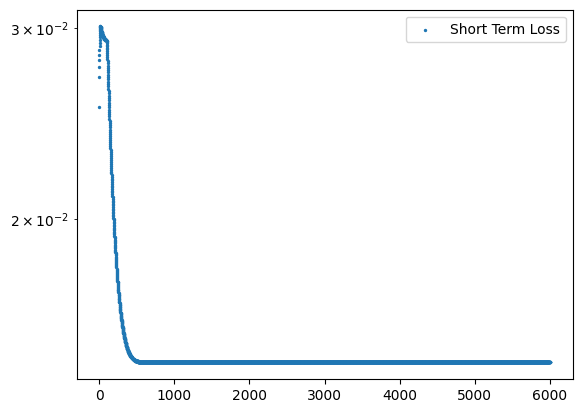

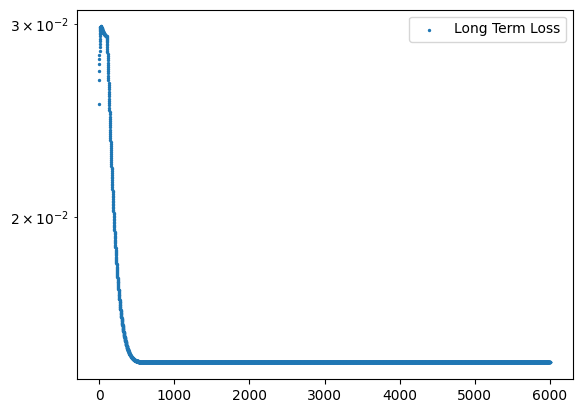

In [26]:
long_term_ema = plot_ewma_losses(epochs=Nepochs_losses, losses=losses)

In [27]:
best_val_loss = long_term_ema[0]
num_bads = 0
for i in range(long_term_ema.shape[0]):
    if num_bads > 50:
        break
    bad = long_term_ema[i] >= best_val_loss *(1.-1e-3)
    if bad:
        num_bads += 1
        print(i, (1-long_term_ema[i]/best_val_loss)*1e3, num_bads)
    else:
        num_bads = 0
        print(i, (1-long_term_ema[i]/best_val_loss)*1e3)
    if long_term_ema[i] < best_val_loss*(1.-1e-3):
        best_val_loss = long_term_ema[i]

0 0.0 1
1 -52.964588555653336 2
2 -72.56001251005273 3
3 -86.87981821858726 4
4 -98.94408974580138 5
5 -109.39160923427748 6
6 -118.72898782144081 7
7 -127.15608701243175 8
8 -134.72887468471862 9
9 -141.54257943982284 10
10 -147.64420682885816 11
11 -153.08994704159917 12
12 -157.90100767791571 13
13 -162.09095040010425 14
14 -165.71670730339628 15
15 -168.80421314419357 16
16 -171.39174267717848 17
17 -173.46281064863845 18
18 -174.98114578997505 19
19 -176.03676245630862 20
20 -176.7045668896372 21
21 -177.02284436705494 22
22 -177.16125925874994 23
23 -177.13310711772357 24
24 -177.0244750183074 25
25 -176.85228322935376 26
26 -176.5988773888434 27
27 -176.27723304105936 28
28 -175.76830837535985 29
29 -175.20497307620707 30
30 -174.75508661849105 31
31 -174.25985809835387 32
32 -173.62688494131694 33
33 -173.02214559035843 34
34 -172.41396978377233 35
35 -171.82249684973084 36
36 -171.59098725032095 37
37 -171.3918076828873 38
38 -170.86574706056211 39
39 -170.26795802642658 40
40

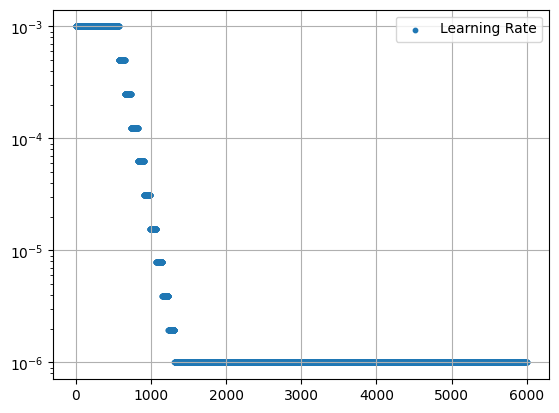

In [28]:
with open((config.scoreNet_trained_path.replace("/trained_models/", "/training_losses/")+ "_loss_LR"), 'rb') as f:
        LRs = (np.array(pickle.load(f)).astype(float))
start = 0
end = -1
plt.scatter(np.arange(LRs.shape[0]),  LRs, s=10, label="Learning Rate")
plt.yscale("log")
plt.grid(True)
plt.legend()
plt.show()
plt.close()

In [29]:
minx = -1.5
assert config.sin_space_scale == 25.
ts_type = "fQuadSin2"
include = (f"{config.deltaT:.3e}dT_{config.quad_coeff}a_{config.sin_coeff}b_{config.sin_space_scale}c").replace(
    ".", "")
root_score_dir = root_dir + f"ExperimentResults/TSPM_Markovian/QuadSinHFT64/"
maxx = -minx

In [30]:
root_score_dir

'/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/ExperimentResults/TSPM_Markovian/QuadSinHFT64/'

In [31]:
NSTgt = "NSTgt" if not config.stable_target else ""
NSTgt += "NFMReg_" if not config.enforce_fourier_mean_reg else ""
ts_type_str = f"ST_{config.feat_thresh:.3f}FTh_{NSTgt}fQuadSinHF".replace(".","")
dirname = "QuadSinHFT64"
label = "$\mu_{2}$"

In [32]:
import pandas as pd
root_score_dir = root_dir + f"ExperimentResults/TSPM_Markovian/{dirname}/"
mses=[]
for file in os.listdir(root_score_dir):
    if "MSE" in file and "Diff01" not in file and "Diff100" not in file:
        print(file)
        mses.append(pd.read_parquet(root_score_dir+file, engine="fastparquet"))
mses = pd.concat(mses).reset_index(drop=False).rename({"index":"epoch"}, axis=1).sort_values("epoch").reset_index(drop=True)
Nepochs_track = mses["epoch"].values.flatten()

TSPM_MLP_ST_0002FTh_NSTgtNFMReg_fQuadSinHF_DriftEvalExp_4410Nep_00t0_1562e-02dT_05a_004b_250c_10ResLay_2LFac_BetaMax20e+01_muhats_MSE.parquet
TSPM_MLP_ST_0002FTh_NSTgtNFMReg_fQuadSinHF_DriftEvalExp_642Nep_00t0_1562e-02dT_05a_004b_250c_10ResLay_2LFac_BetaMax20e+01_muhats_MSE.parquet
TSPM_MLP_ST_0002FTh_NSTgtNFMReg_fQuadSinHF_DriftEvalExp_4824Nep_00t0_1562e-02dT_05a_004b_250c_10ResLay_2LFac_BetaMax20e+01_muhats_MSE.parquet
TSPM_MLP_ST_0002FTh_NSTgtNFMReg_fQuadSinHF_DriftEvalExp_1560Nep_00t0_1562e-02dT_05a_004b_250c_10ResLay_2LFac_BetaMax20e+01_muhats_MSE.parquet
TSPM_MLP_ST_0002FTh_NSTgtNFMReg_fQuadSinHF_DriftEvalExp_5571Nep_00t0_1562e-02dT_05a_004b_250c_10ResLay_2LFac_BetaMax20e+01_muhats_MSE.parquet
TSPM_MLP_ST_0002FTh_NSTgtNFMReg_fQuadSinHF_DriftEvalExp_3015Nep_00t0_1562e-02dT_05a_004b_250c_10ResLay_2LFac_BetaMax20e+01_muhats_MSE.parquet
TSPM_MLP_ST_0002FTh_NSTgtNFMReg_fQuadSinHF_DriftEvalExp_3234Nep_00t0_1562e-02dT_05a_004b_250c_10ResLay_2LFac_BetaMax20e+01_muhats_MSE.parquet
TSPM_ML

In [33]:
common_epochs = np.intersect1d(Nepochs_losses, Nepochs_track)
common_epochs = np.intersect1d(common_epochs, np.arange(500, 20000))
start_idx = 0
common_epochs = common_epochs[start_idx:]
losses_idx = np.unique([np.argwhere(c == Nepochs_losses)[0,0] for c in common_epochs])
track_idx = np.unique([np.argwhere(c == Nepochs_track)[0,0] for c in common_epochs])
red_losses = losses[losses_idx]
print(track_idx.shape, common_epochs.shape)
#track_rmses = np.array(list(drift_track_rmses.values()))[track_idx]
track_rmses = mses.iloc[track_idx,:].mse.values.flatten()
eval_rmses = track_rmses
print(track_rmses.shape, common_epochs.shape)

(1833,) (1833,)
(1833,) (1833,)


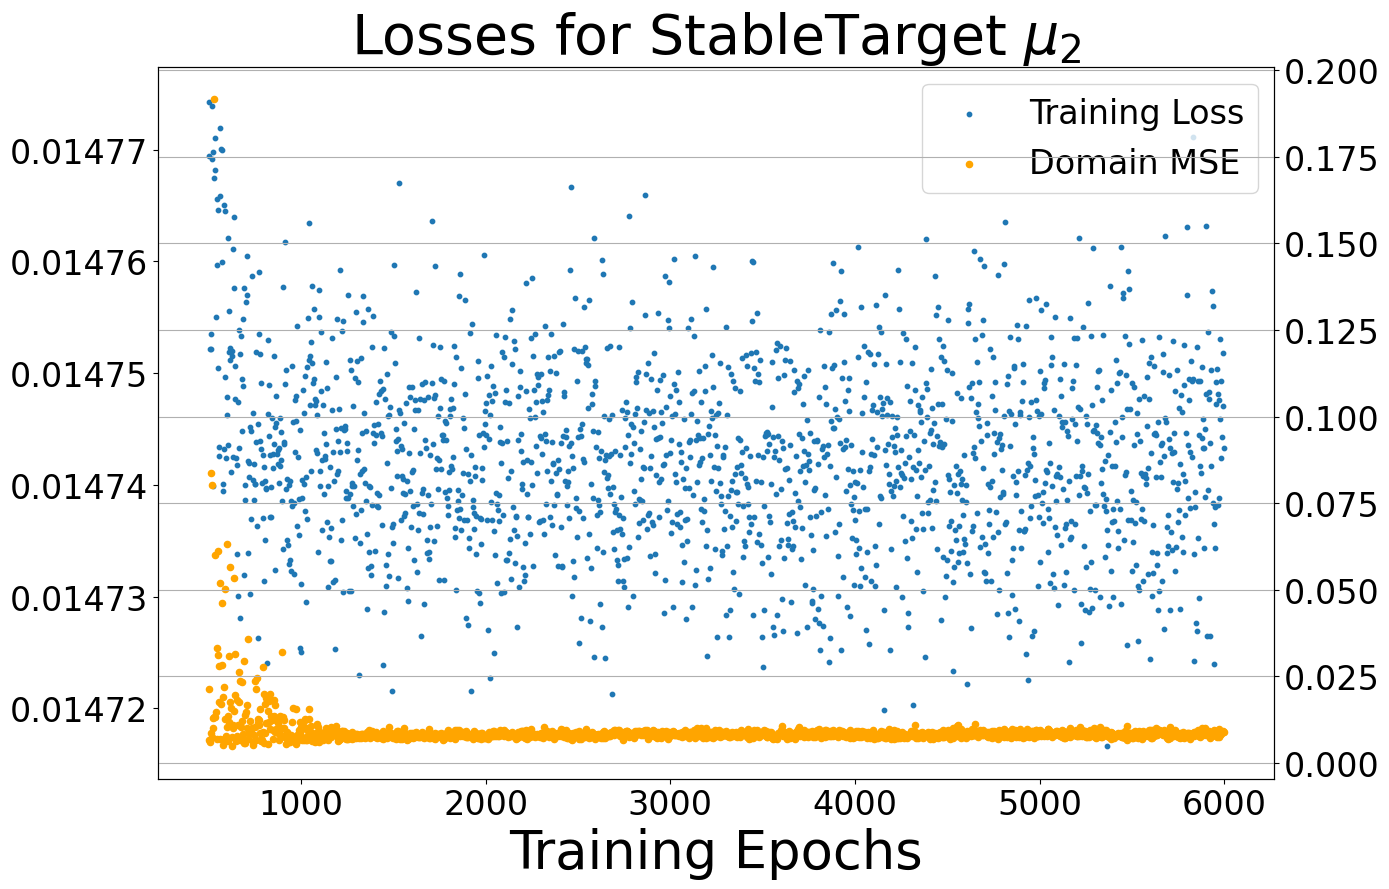

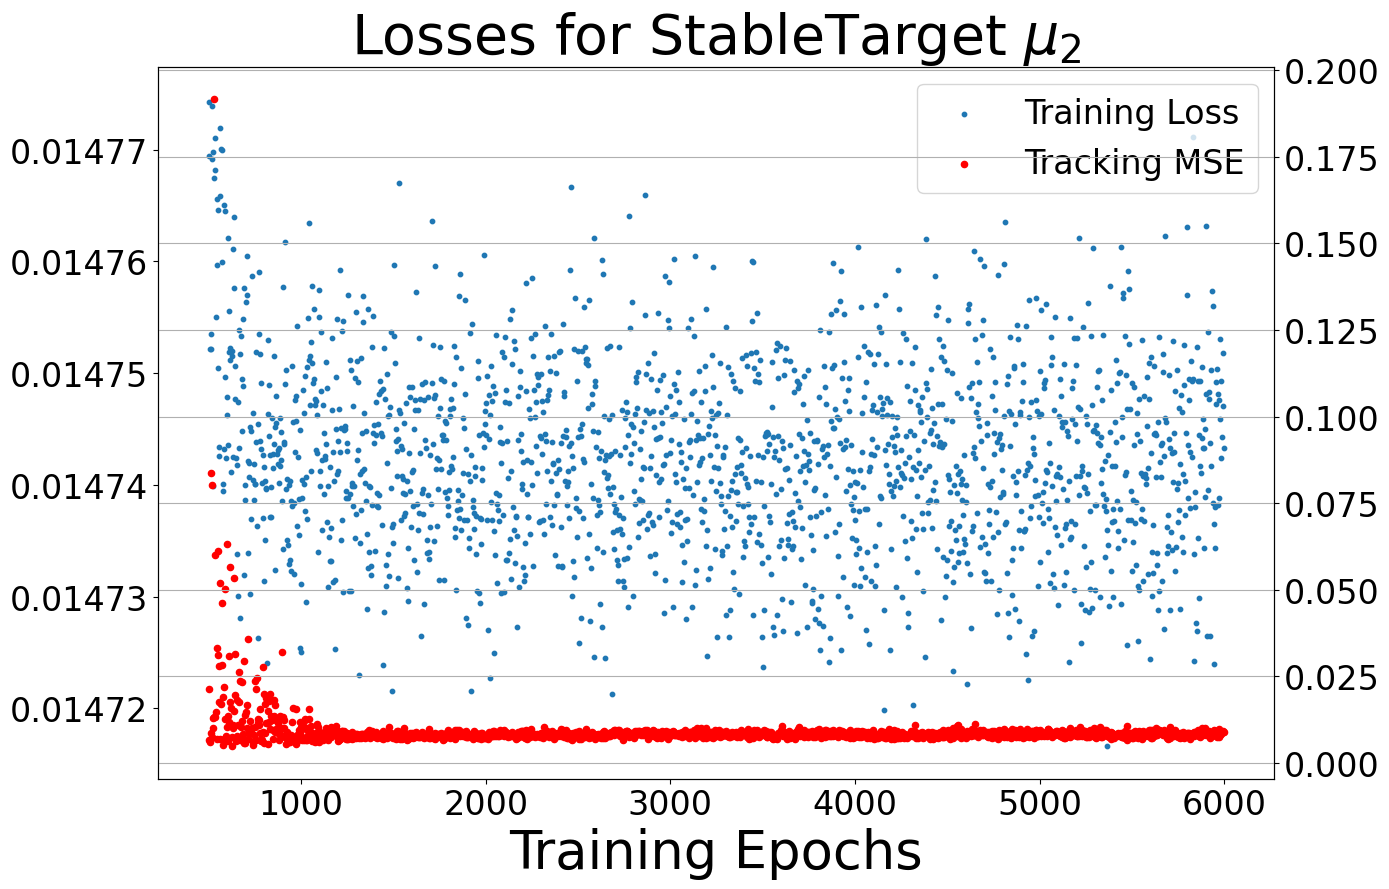

      epoch       mse
0         1  5.916741
1         2  4.287711
2         3  1.146675
3         5  0.976841
4         6  0.842383
...     ...       ...
2014   5988  0.009005
2015   5991  0.009190
2016   5994  0.008855
2017   5997  0.008841
2018   6000  0.009046

[2019 rows x 2 columns]


In [34]:
toSave = False
fig, ax = plt.subplots(figsize=(14,9))
sc1 = ax.scatter(common_epochs, red_losses, s=10, label="Training Loss")
ax.tick_params(axis="both",labelsize=24)
ax2 = ax.twinx()
sc2 = ax2.scatter(common_epochs, eval_rmses, s=20, color="orange",label="Domain MSE")
ax.set_xlabel("Training Epochs", fontsize=38)
ax.set_title(rf"Losses for StableTarget {label}", fontsize=40)
ax.tick_params(axis="both",labelsize=24)
ax2.tick_params(axis="both",labelsize=24)
plt.tight_layout()
handles = [sc1, sc2]
labels = [h.get_label() for h in handles]
ax.legend(handles, labels, fontsize=24)
if toSave:
    plt.savefig((root_dir +f"DiffusionModelPresentationImages/TSPM_Markovian/{dirname}/TSPM_MLP_PM_ST_{config.feat_thresh:.3f}FTh_{ts_type}_LossesEvalExp_{config.loss_factor}LFac").replace(".","")+".png",  bbox_inches='tight')
plt.grid(True)
plt.show()
plt.close()
fig, ax = plt.subplots(figsize=(14,9))
sc1 = ax.scatter(common_epochs, red_losses, s=10, label="Training Loss")
ax2 = ax.twinx()
sc2 = ax2.scatter(common_epochs, track_rmses, s=20, color="red",label="Tracking MSE")
ax.set_xlabel("Training Epochs", fontsize=38)
ax.set_title(rf"Losses for StableTarget {label}", fontsize=40)
ax.tick_params(axis="both",labelsize=24)
ax2.tick_params(axis="both",labelsize=24)
plt.tight_layout()
handles = [sc1, sc2]
labels = [h.get_label() for h in handles]
# Add a single legend on ax1
ax.legend(handles, labels, fontsize=24)
if toSave:
    plt.savefig((root_dir + f"DiffusionModelPresentationImages/TSPM_Markovian/{dirname}/TSPM_MLP_PM_ST_{config.feat_thresh:.3f}FTh_{ts_type}_LossesTrack_{config.loss_factor}LFac").replace(".","")+".png",  bbox_inches='tight')
plt.grid(True)
plt.show()
plt.close()
print(mses)

In [35]:
print(mses.iloc[np.argmin(mses.mse),:])

epoch    368.000000
mse        0.004217
Name: 140, dtype: float64


In [36]:
raise RuntimeError

RuntimeError: 

In [ ]:
best_rmse = np.inf
m_mu_hats = []
toSave = True
for f in zip(*[common_epochs, driftevalexp_files]):
    print(f)
    Nepoch = f[0]
    file = f[1]
    if Nepoch not in common_epochs: continue
    if Nepoch != best_epoch_eval: continue
    try:
        muhats = torch.Tensor(np.load(file, allow_pickle=True))
        Xshape = muhats.shape[0]
        Xs = torch.Tensor(np.linspace(-1.5,1.5,Xshape))
        if "BiPot" in config.data_path:
            true_drifts = -(4.*config.quartic_coeff * np.power(Xs, 3) + 2.*config.quad_coeff * Xs + config.const).numpy()
        elif "QuadSin" in config.data_path:
            true_drifts = (-2. * config.quad_coeff * Xs + config.sin_coeff * config.sin_space_scale * np.sin(
        config.sin_space_scale * Xs)).numpy()
        elif "SinLog" in config.data_path:
            true_drifts = (-np.sin(config.sin_space_scale*Xs)*np.log(1+config.log_space_scale*np.abs(Xs))/config.sin_space_scale).numpy()
        #print(Nepoch, muhats.shape, true_drifts.shape)
        muhats = muhats[:, -1, :].reshape(muhats.shape[0], muhats.shape[2]*1)
        print(muhats.shape)
        mu_hats = muhats.mean(dim=-1).numpy()
        rmse = rmse_ignore_nans(true_drifts, mu_hats).astype(np.float64)
        print(rmse)
        if rmse < best_rmse:
            print(muhats.shape)
            mu_hats_minq = muhats.quantile(dim=-1, q=0.005).numpy() # Lower bound
            mu_hats_maxq = muhats.quantile(dim=-1, q=0.995).numpy() # Upper boun
            best_rmse = rmse
            print(mu_hats_maxq.shape)
            plot_drift_estimator(mean=mu_hats, mean_min=mu_hats_minq, mean_max=mu_hats_maxq, dirname=dirname, numpy_Xs=Xs.numpy(),  toSave=toSave, true_drift=true_drifts, Nepoch=Nepoch, label=label)
            print(f"MSE {rmse} at Nepoch {Nepoch}\n")
            print(file)
    except FileNotFoundError as e:
        print(f"{e}, Hi")
#m_mu_hats = torch.Tensor(np.array(m_mu_hats))
#m_mu_hats = m_mu_hats.numpy()
#mu_hats = m_mu_hats.mean(axis=0)


In [ ]:
curr_rmse = np.inf
toSave = False
i = 0
for file in zip(*[driftoostrack_true_files, driftoostrack_local_files, common_epochs]):
    Nepoch = file[-1]
    all_true_states = np.load(file[0])
    all_local_states = np.load(file[1])
    if Nepoch != best_epoch_track:
        continue
    print(Nepoch, file)
    if (len(all_true_states.shape) == len(all_local_states.shape) == 4):
        time_steps = np.linspace(config.t0,config.deltaT*all_true_states.shape[2],all_true_states.shape[2])
        all_local_errors = np.sum(np.power(all_true_states- all_local_states,2), axis=-1)
        all_local_errors = all_local_errors.reshape(-1, all_local_errors.shape[-1])
        total_local_errors = np.sqrt(np.mean((all_local_errors), axis=0))/np.sqrt(time_steps)
        all_errs = np.sqrt(all_local_errors)/np.sqrt(time_steps)
        total_local_errors[np.isinf(total_local_errors)] = 0.
        all_errs[np.isinf(all_errs)] = 0.
        total_local_errors_minq, total_local_errors_maxq = np.quantile(all_errs, axis=0,q=[0.005,0.995])
        i += 1
        if total_local_errors[-1]  < curr_rmse:
            curr_rmse = total_local_errors[-1]
            fig, ax = plt.subplots(figsize=(14,9))
            plt.grid(True)
            ax.scatter(time_steps, total_local_errors)
            plt.fill_between(time_steps,y1=total_local_errors_minq, y2=total_local_errors_maxq, color="blue", alpha=0.4)
            ax.set_title(f"Pathwise RMSE for Score Estimator for {label}",fontsize=40)

            ax.set_xlabel("Time Axis", fontsize=38)
            ax.tick_params(labelsize=38)

            fig.canvas.draw()
            # Get the offset text (e.g., '1e-5')
            offset_text = ax.yaxis.get_offset_text().get_text()

            # Remove the offset text from the axis
            ax.yaxis.get_offset_text().set_visible(False)

            # Inject the scale into the y-axis label
            if offset_text:
                ax.set_ylabel(f'RMSE ({offset_text})', fontsize=38)
            else:
                ax.set_ylabel('RMSE', fontsize=38)
            plt.tight_layout()
            if toSave:
                plt.savefig((root_dir +f"DiffusionModelPresentationImages/TSPM_Markovian/{dirname}/TSPM_MLP_PM_ST_{config.feat_thresh:.3f}FTh_{ts_type}_DriftTrack_{Nepoch}Nep_{round(total_local_errors_minq[-1], 7)}_MinIQR_{round(total_local_errors_maxq[-1], 7)}_MaxIQR").replace(".", "")+".png")
            plt.grid(True)
            plt.show()
            plt.close()
            print(f"Final time cumulative MSE local-time error {total_local_errors[-1]} with IQR ({total_local_errors_minq[-1], total_local_errors_maxq[-1]})at Nepoch {Nepoch}\n")
            print(file)